# Initialize data

In [17]:
# initialize data 
###
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# plot table
import texttable as tt

def plotTable(headers,
              rows,
              valign=True,
              column_width=False,
              no_deco=False,
              precision=1):
    tab = tt.Texttable()
    if len(headers) > 0:
        tab.header(headers)
    tab.set_precision(precision)
    for row in rows:
        tab.add_row(row)

    if valign and len(headers) > 0:
        tab.set_cols_valign(['m'] * len(headers))

    if column_width:
        columns = [0] * len(rows[0])
        for row in rows:
            for i, cell in enumerate(row):
                if isinstance(row[i], str):
                    columns[i] = max(
                        columns[i],
                        max([len(line) for line in row[i].split('\n')]))
        for i, head in enumerate(headers):
            columns[i] = max(columns[i], len(head))
        tab.set_cols_width(columns)

    if no_deco:
        tab.set_deco(tt.Texttable.HEADER | tt.Texttable.VLINES)

    s = tab.draw()
    return s

def data_from_file(file_name):
    data = np.loadtxt(file_name)
    ids = data[0, :]    
    dfs = data[1:, :]
    iqs = list(range(180, -1, -10))
    xLabel = 'd-axis current - Id [A]'
    yLabel = 'Direct flux linkage [Wb]'
    Is = 'Iq '
    return ids, dfs, iqs, Is, xLabel, yLabel


ids, dfs, iqs, Is, xLabel, yLabel = data_from_file('PMASynRM_input_data/D_d_madalina.txt')

# Plot original curves = o coloana din D_d este o curba Iq

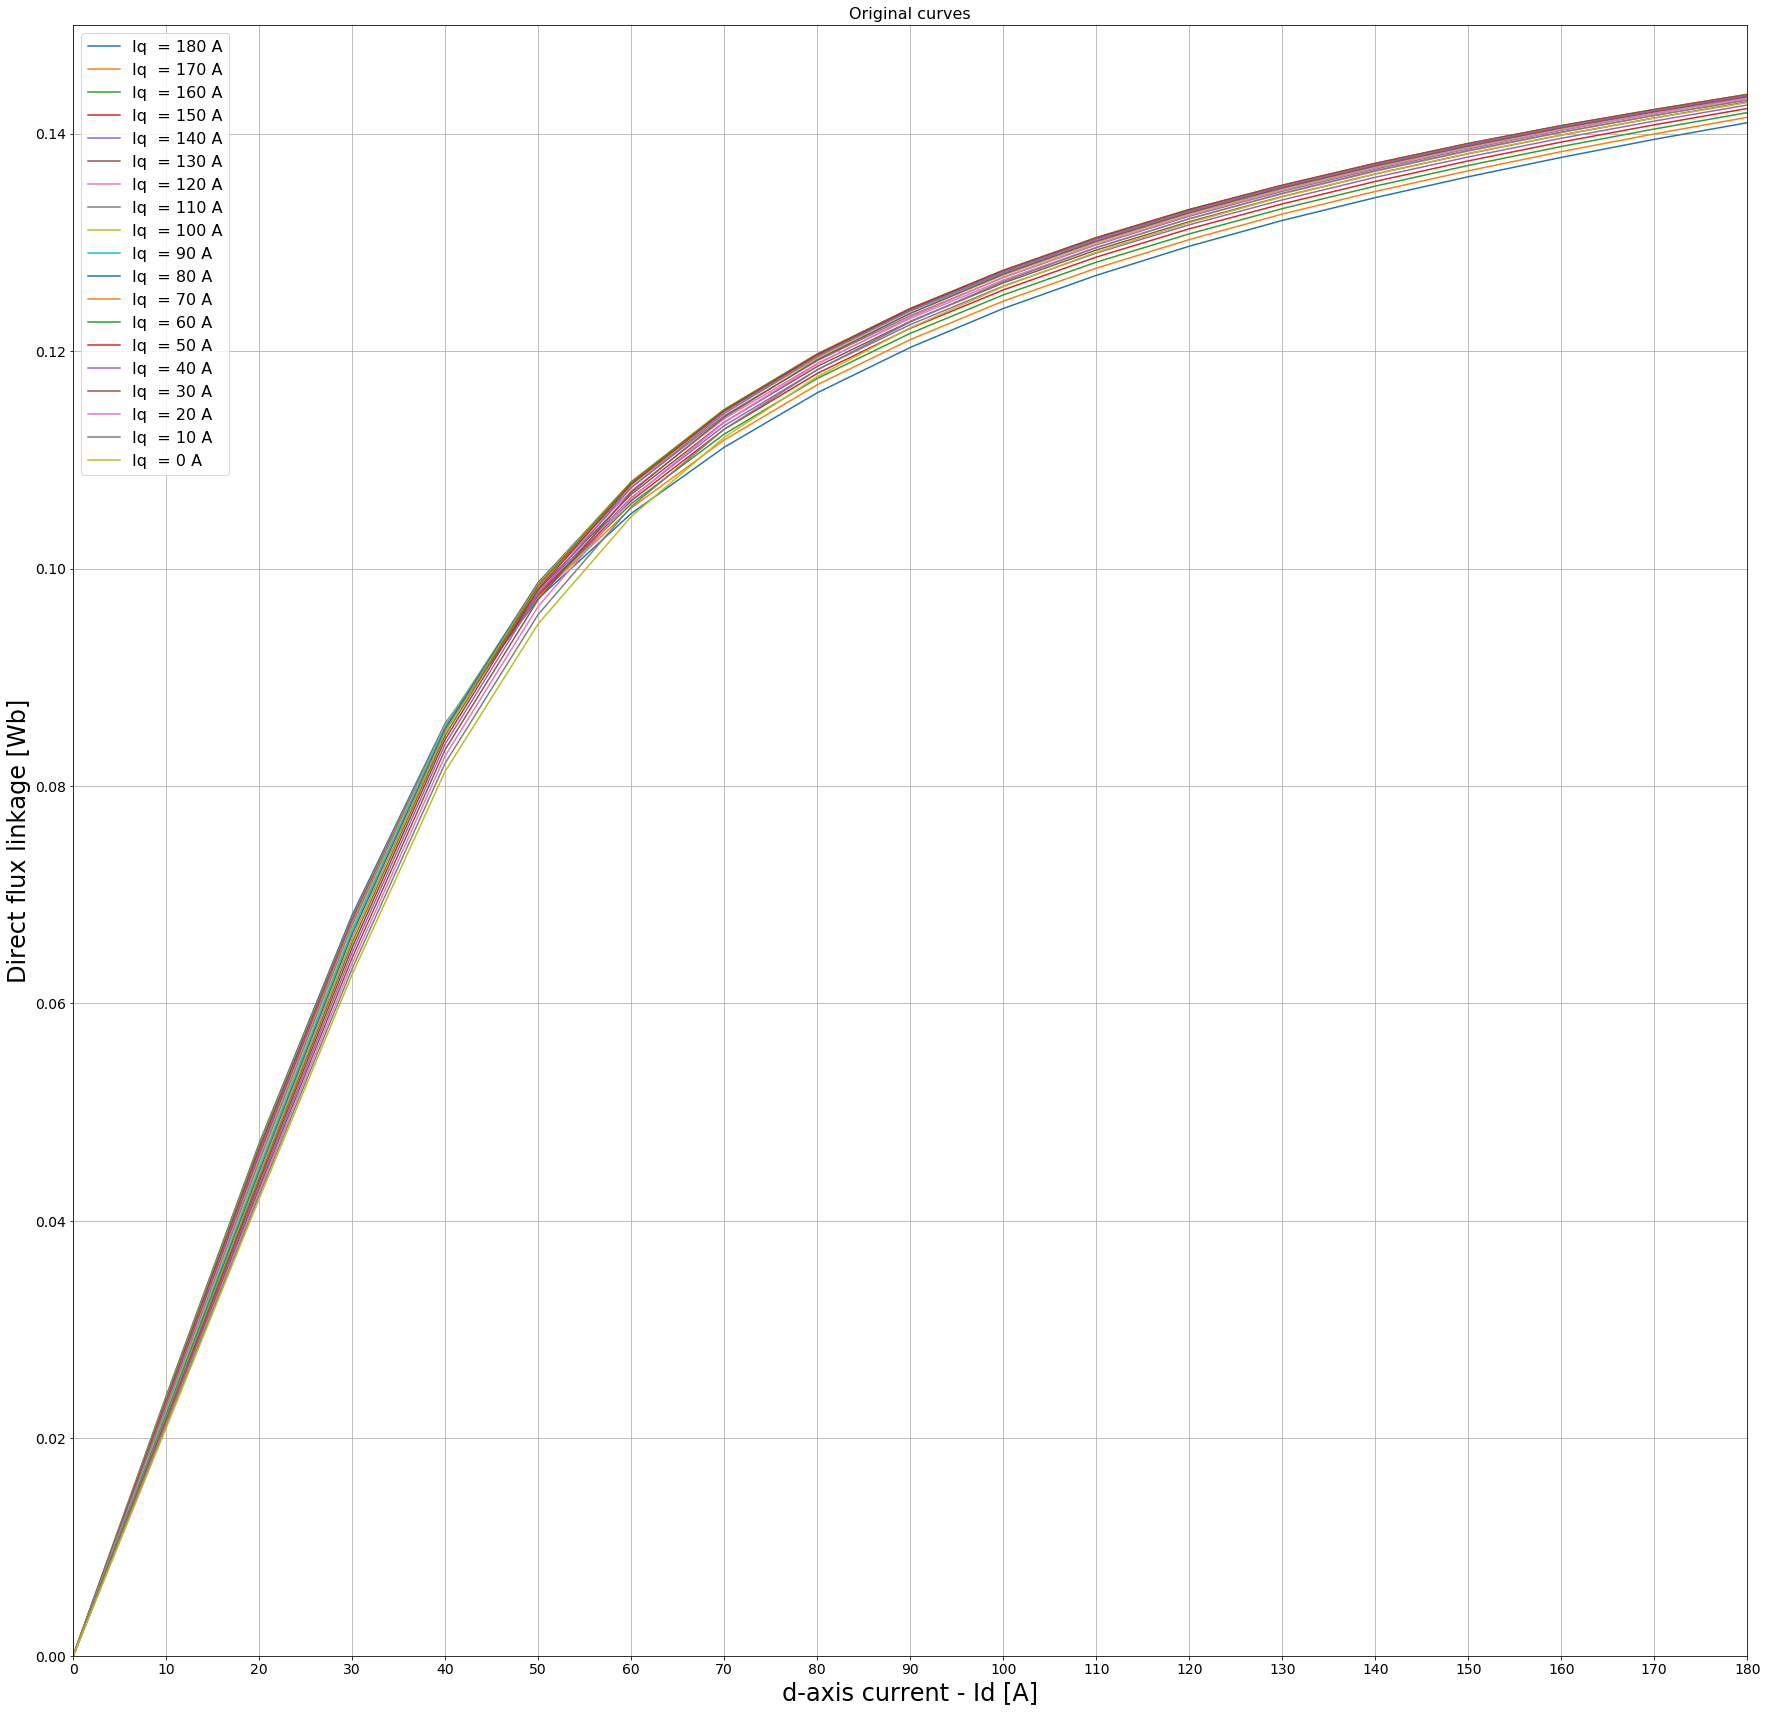

In [31]:
#

from subprocess import call
plt.clf()
plt.rcParams["figure.figsize"] = [30,30]
plt.rcParams['xtick.labelsize']=14
plt.rcParams['ytick.labelsize']=14

curves = list(range(0,19))

for idx in curves:
    df = dfs[:,idx]
    
    plt.plot(ids, df, label='%s = %d A' %(Is,iqs[idx]))
    plt.ylim([0, 0.15])
    plt.xlim([0, 180])
    plt.xticks(ids)
    plt.xlabel(xLabel, fontsize = 24)
    plt.ylabel(yLabel, fontsize = 24)
    plt.legend(loc='best', fontsize = 16)
plt.grid()
plt.title('Original curves', fontsize = 16)
plt.savefig('PMASynRM_output/PMA_D_d_Original_Iqs.pdf', dpi = 300)
plt.show()

# [REDUCE_POINTS] PCA to reduce the number of defining point (ids from Ox axis)



Ideas:

    Reduce the number of points, using PCA
    Pt. reconstructie:
        Spline pe nr redus de puncte
        Loss intre Spline si curbele initiale



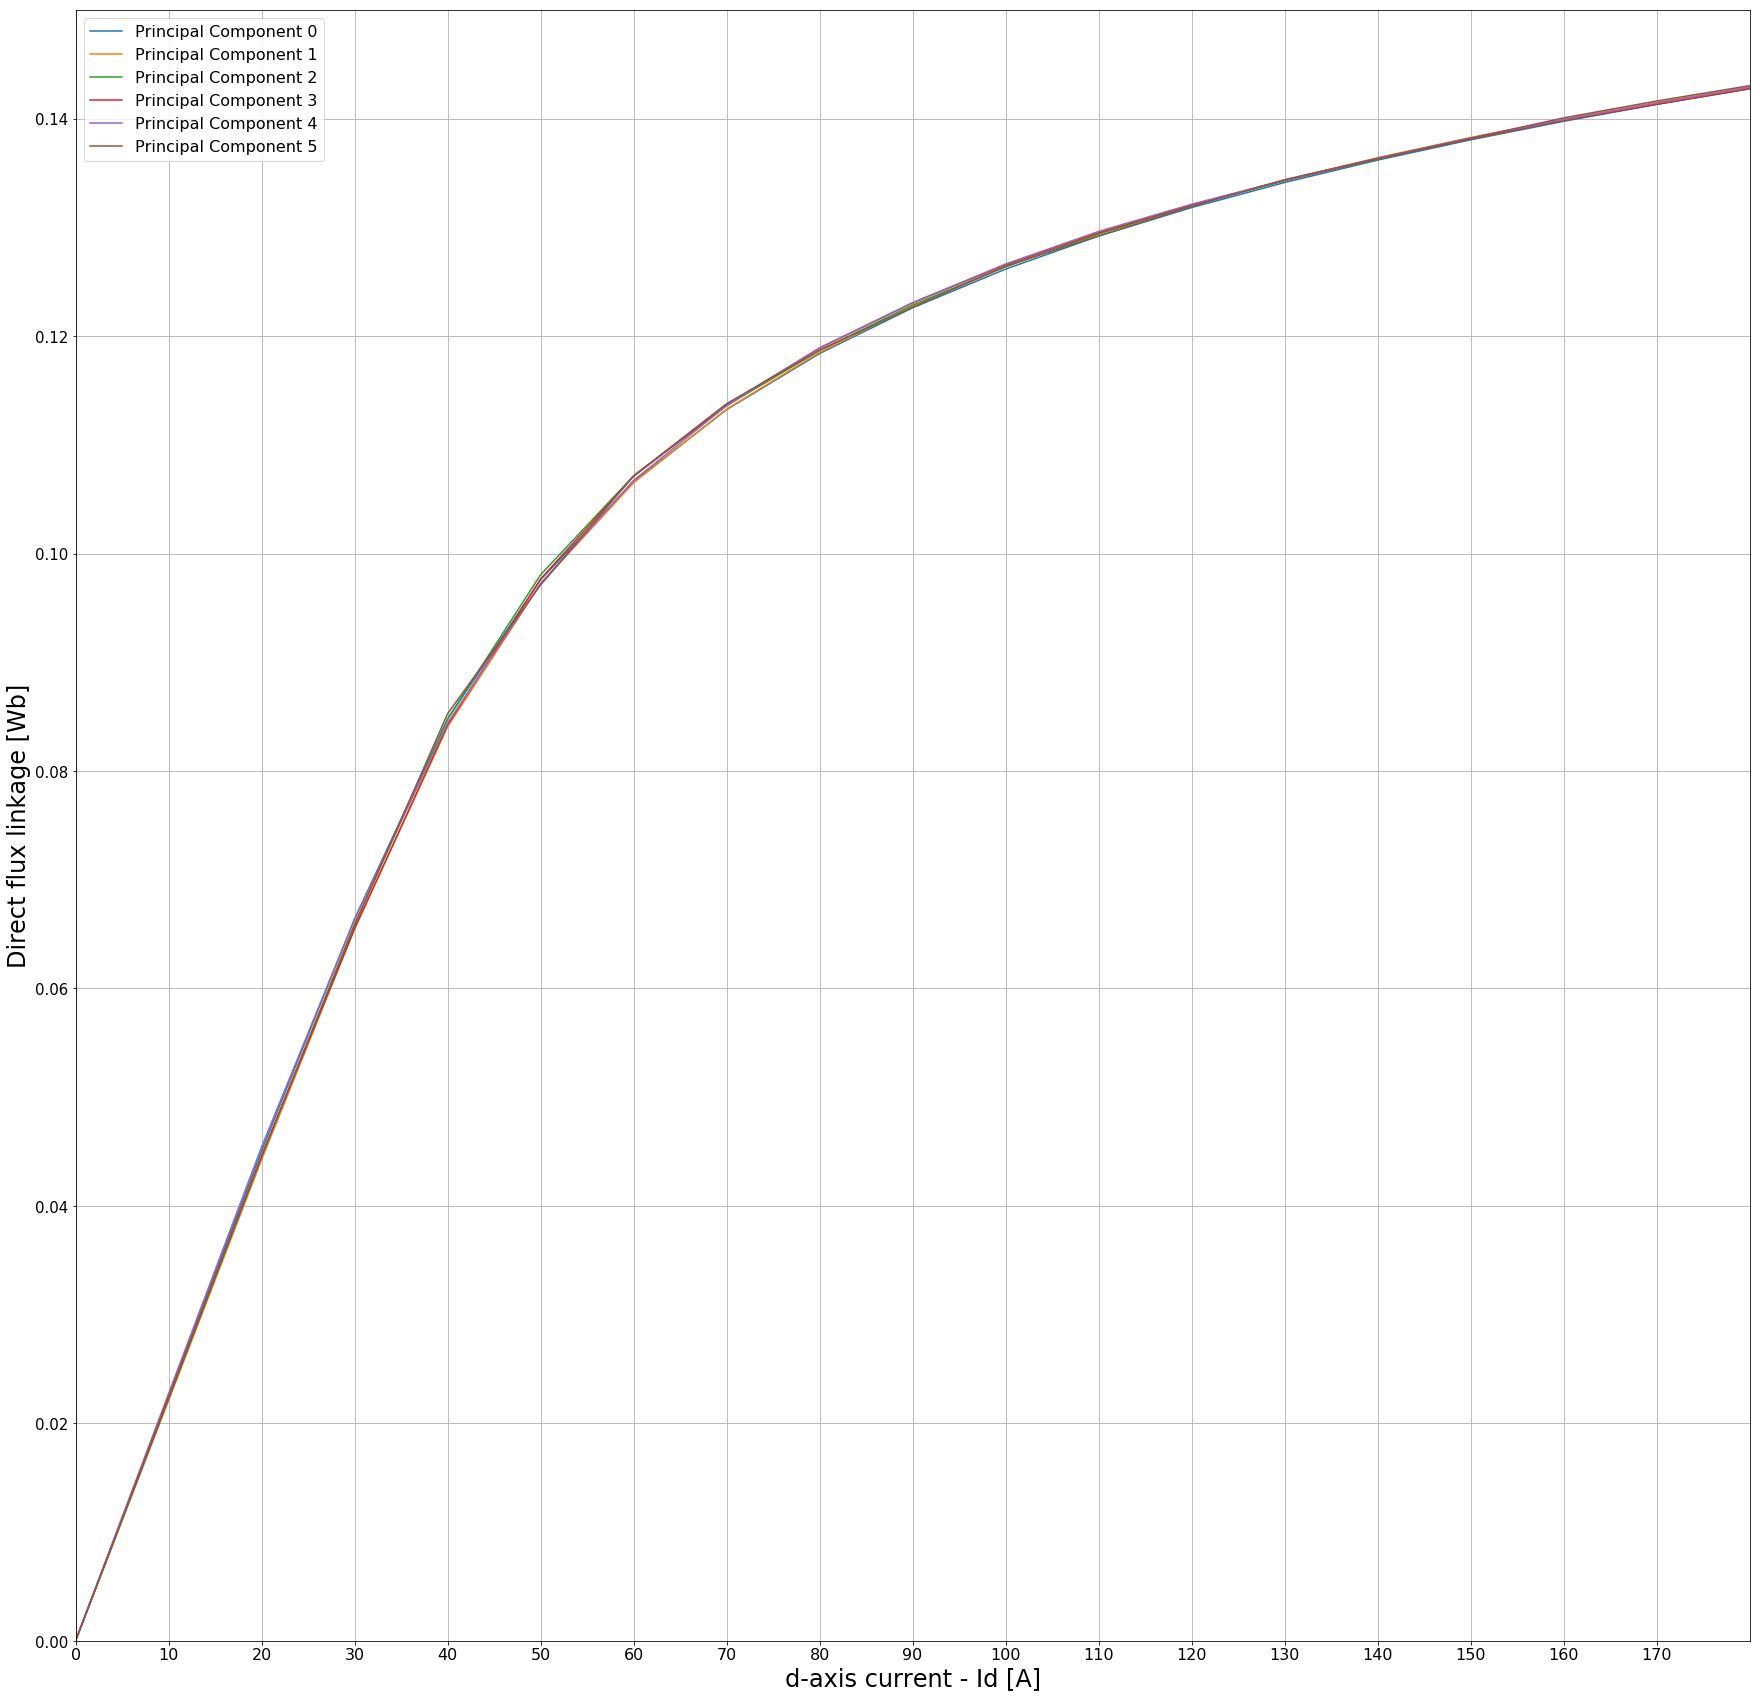

In [19]:
#
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy import interpolate
from sklearn.decomposition import PCA
from sklearn import preprocessing
from pandas import DataFrame as df

#INITIALIZE THE TABLE 
headers =[ 'No of PCs' ]+['Total Error'] + ['Id %d'%id for id in ids] 
rows    = []

#preprocess the data
flux = dfs.T
scaler = preprocessing.StandardScaler()
df_flux_scaled = scaler.fit_transform(flux)
weights  = []

avg_Iqs_weights_headers = ['Components'] + ['Iq %d' % iq for iq in ids]
avg_Iqs_weights_rows = []

no_of_comps = [6]
for comp in no_of_comps:
    row = [comp]
    pca_reduce_curves = PCA(n_components=comp)
    flux_reduced = pca_reduce_curves.fit_transform(df_flux_scaled)
    projected  = pca_reduce_curves.inverse_transform(flux_reduced)
    projected_unscaled = scaler.inverse_transform(projected)

    # plot reconstructions
#     for curve in range(0, flux.shape[0], 4):
#         plt.clf()
#         plt.rcParams["figure.figsize"] = [12,8]
#         plt.rcParams['xtick.labelsize']=12
#         plt.rcParams['ytick.labelsize']=12
#         plt.plot(x_new, flux[curve, :], label = 'original', color = 'black')
#         plt.plot(x_new, projected_unscaled[curve, :], label = 'projected')
#         plt.legend()
#         plt.title('IQ: %d pca_comp: %d' % (iqs[curve], comp))
#         plt.grid()
#         plt.show() 

    
    # plot main components
    plt.clf()
    plt.rcParams["figure.figsize"] = [20,20]
    plt.rcParams['xtick.labelsize']=24
    plt.rcParams['ytick.labelsize']=24
    
    components = pca_reduce_curves.components_
    components = scaler.inverse_transform(components)
    
    for idx in range(components.shape[0]):
        plt.plot(ids, components[idx, :], label='Principal Component %d'%idx)
        plt.xlabel(xLabel,fontsize=24)
        plt.ylabel(yLabel,fontsize=24)
        plt.legend(fontsize=16)  
        plt.xticks(list(range(0, 180, 10)),fontsize= 16)
        plt.yticks(fontsize = 15)
        plt.xlim(0, 180)
        plt.ylim(0,0.15)
    plt.grid()
    plt.savefig('PMASynRM_output/PMA_reduce_points_TOP{}_PrincipalComponents.pdf'.format(comp), dpi = 200)  
    plt.show() 
    
    error = (flux - projected_unscaled) ** 2
    error = np.sum(error, axis=1)
    error = error.astype(np.float64) * (10 ** 6)
    row.append(sum(error))
    row = row + error.tolist() 
    
    rows.append(row)
    
    #table - meaning of PCs  
    headers_PC =[ 'Idx of PC' ] + ['Iq %d' % id for id in ids] 
    rows_PC    = []
    i = 1
    for component in pca_reduce_curves.components_:
        row_PC = [i]
        for value in component:
            row_PC.append(value)
        i+=1
        rows_PC.append(row_PC)
        
    # average contribution of each feature
    avg_weights = np.mean(abs(pca_reduce_curves.components_), axis=0)
    weights.append(avg_weights.tolist())
#     avg_weights_data. append()
    avg_Iqs_weights_rows.append([comp] + avg_weights.tolist())
    
# print PC meaning   
# print ("Meaning of the %d components(Weights for each IQ curve)"  %comp)
# table_PC = plotTable(headers=headers_PC, rows=rows_PC, column_width=True, precision=5) 
# print(table_PC)

# print errors in table    
# print('Loss (sum squared error * 10 ^ 6)')
np_weights = np.asarray(weights, dtype=np.float32)

data = np_weights.T

df_weights = df(data = np.round(np_weights.T, 1), index = iqs, columns = no_of_comps)
# print(df_weights)
df_weights.to_csv('PMASynRM_output/PMA_reduce_points_average_weights_of_curves_in_PCA.csv')
# print('Average contribution of each curve -- for diff num of components')
# table = plotTable(avg_Iqs_weights_headers, avg_Iqs_weights_rows, column_width=True)
# print(table)

# [REDUCE_POINTS] PCA error plot

components shape:  (15, 19)


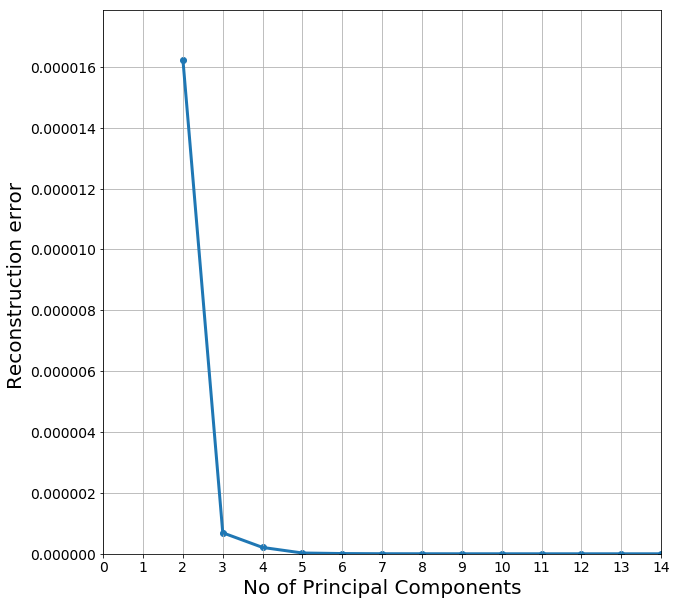

In [27]:
#preprocess the data
X = np.copy(dfs)
scaler = preprocessing.StandardScaler()
df_flux_scaled = scaler.fit_transform(X)
no_of_comps = range(2, 16)

errors = []
for comp in no_of_comps:
    pca_reduce_points = PCA(n_components=comp)
    flux_reduced = pca_reduce_points.fit_transform(df_flux_scaled)
    projected  = pca_reduce_points.inverse_transform(flux_reduced)
    projected_unscaled = scaler.inverse_transform(projected)
    errors.append(np.sum((projected_unscaled - X) ** 2))
print('components shape: ', pca_reduce_points.components_.shape)

plt.figure(figsize=(10, 10))
plt.xlabel('No of Principal Components', fontsize = 20)
plt.ylabel('Reconstruction error ', fontsize = 20)
plt.xlim([0,14])
plt.ylim([0.1*min(errors), 1.1*max(errors)])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.locator_params(axis='x', nbins=len(no_of_comps))
plt.scatter(no_of_comps, errors)
plt.plot(no_of_comps, errors, linewidth=3)
plt.grid()
# plt.title('PCA for reducing number of currents', fontsize=16)
plt.savefig('PMASynRM_output/PMA_reduce_points_PCA_errors.pdf', dpi = 200)
plt.show()


# [REDUCE CURVES] original plots

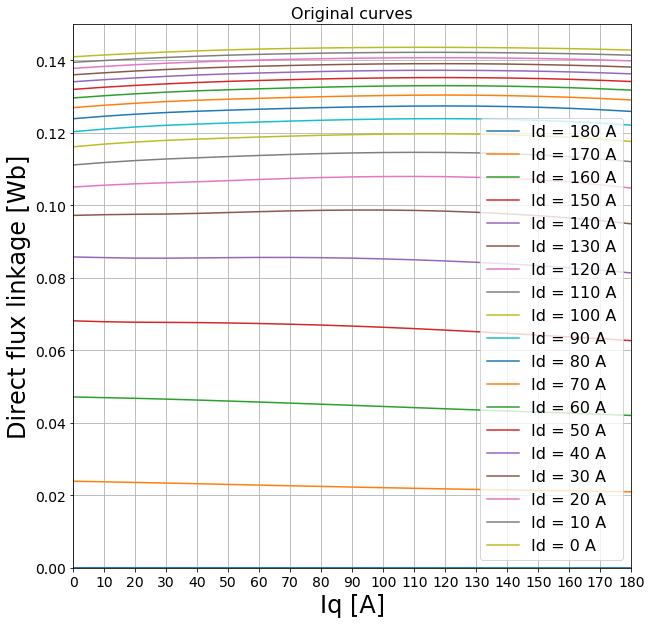

In [64]:
from subprocess import call
plt.clf()
plt.rcParams["figure.figsize"] = [10,10]
plt.rcParams['xtick.labelsize']=14
plt.rcParams['ytick.labelsize']=14

curves = list(range(0,19))
flux = dfs.T

for idx in curves:
    df = flux[:,idx]
    
    plt.plot(ids, df, label='Id = %d A' %(iqs[idx]))
    plt.ylim([0, 0.15])
    plt.xlim([0, 180])
    plt.xticks(ids)
    plt.xlabel("Iq [A]", fontsize = 24)
    plt.ylabel(yLabel, fontsize = 24)
    plt.legend(loc='best', fontsize = 16)
plt.grid()
plt.title('Original curves', fontsize = 16)
plt.savefig('PMASynRM_output/PMA_reduce_curve_original_plot.pdf', dpi = 300)
plt.show()

# # # [REDUCE_POINTS] Ridge 

In [39]:
from sklearn.linear_model import Ridge
from pandas import DataFrame as df

X = dfs.T
y = list(ids)

model = Ridge(fit_intercept=True, normalize=True)
model.fit(X, y)

# best case 1, worst case -1, random prediction: 0
print('Regression train score: %.2f\n' % model.score(X, y))

#find upper and lower Iq curve
def border_curves(curve, interval):
    left = max([i for i in interval if i < curve])
    right = min([i for i in interval if i > curve])

    ## return index of left/right
    return interval.index(left), interval.index(right)

result = model.predict(components)
print('Predicted Ids (Ox axis coordinates): ')
csv_data = [[] for i in range(len(result))]
for i, pred in enumerate(result):
    left, right = border_curves(round(pred), y)
    print('PCA_comp %d <=> Id = %d A between (%d A, %d A)' % (i+1,round(pred), y[left], y[right]))
    csv_data[i].append(round(pred))
    csv_data[i].append(y[left])
    csv_data[i].append(y[right])

df_pred = df(data= csv_data)

Regression train score: 0.98

Predicted Ids (Ox axis coordinates): 


ValueError: max() arg is an empty sequence

# [REDUCE_CURVES] PCA for reducing the number of Iq curves

dfs from file - > has a IQ curve as a column

1. observed variable: flux at a certain IQ value (flux for a certain value of the  IQ curve)
2. sample: given a d-axis current value, measure flux for different q-axis currents
3. find the Iq (q-axis currents) with highest variance across all ID (d-axis currents)

Meaning of the 6 components(Weights for each IQ curve)
+-----------+------+-------+-------+-------+-------+-------+-------+-------+-------+-------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
| Idx of PC | Iq 0 | Iq 10 | Iq 20 | Iq 30 | Iq 40 | Iq 50 | Iq 60 | Iq 70 | Iq 80 | Iq 90 | Iq 100 | Iq 110 | Iq 120 | Iq 130 | Iq 140 | Iq 150 | Iq 160 | Iq 170 | Iq 180 |
+===========+======+=======+=======+=======+=======+=======+=======+=======+=======+=======+========+========+========+========+========+========+========+========+========+
| 1         | -0.2 | -0.22 | -0.22 | -0.22 | -0.22 | -0.22 | -0.22 | -0.22 | -0.22 | -0.22 | -0.229 | -0.229 | -0.229 | -0.229 | -0.229 | -0.229 | -0.229 | -0.229 | -0.229 |
|           | 2937 | 940   | 941   | 942   | 942   | 943   | 943   | 943   | 943   | 943   | 43     | 43     | 43     | 42     | 42     | 41     | 40     | 39     | 37     |
+-----------+------+-------+-------+-------+-------+-------+-------+-------

ValueError: max_width too low to render data

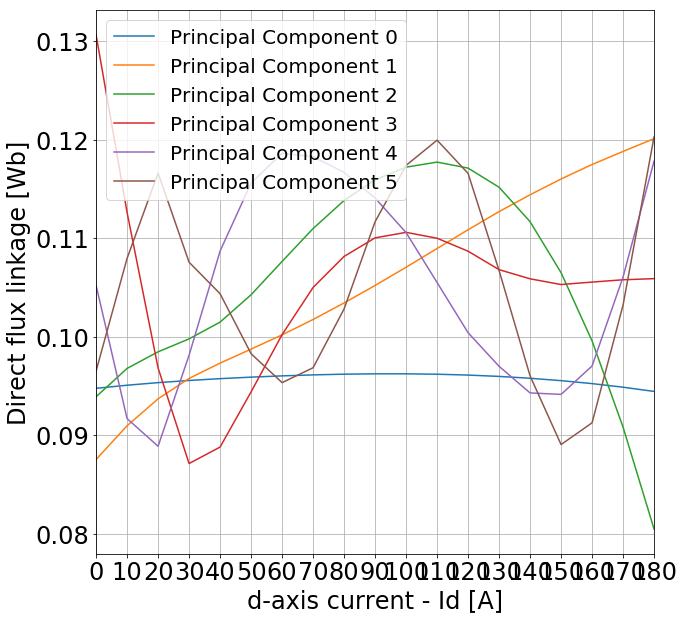

In [65]:
#
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy import interpolate
from sklearn.decomposition import PCA
from sklearn import preprocessing
from pandas import DataFrame as df

#INITIALIZE THE TABLE 
headers =[ 'No of PCs' ]+['Total Error'] + ['Id %d'% a for a in ids] 
rows    = []
plt.clf()
#preprocess the data
flux = dfs
scaler = preprocessing.StandardScaler()
df_flux_scaled = scaler.fit_transform(flux)
weights  = []

avg_Iqs_weights_headers = ['Components'] + ['Iq %d' % iq for iq in ids]
avg_Iqs_weights_rows = []

no_of_comps = [2, 4, 6]
for comp in no_of_comps:
    row = [comp]
    pca_reduce_curves = PCA(n_components=comp)
    flux_reduced = pca_reduce_curves.fit_transform(df_flux_scaled)
    projected  = pca_reduce_curves.inverse_transform(flux_reduced)
    projected_unscaled = scaler.inverse_transform(projected)

   
    # plot main components
    plt.clf()
    plt.rcParams["figure.figsize"] = [20,20]
    plt.rcParams['xtick.labelsize']=24
    plt.rcParams['ytick.labelsize']=24
    
    components = pca_reduce_curves.components_
    components = scaler.inverse_transform(components)
    
    for idx in range(components.shape[0]):
        plt.plot(ids, components[idx, :], label='Principal Component %d'%idx)
        plt.xlabel(xLabel,fontsize=24)
        plt.ylabel(yLabel,fontsize=24)
        plt.legend(fontsize=20)  
        plt.xticks(list(range(0, 190, 10)))
        plt.xlim(0, 180)
    plt.grid()
#     plt.savefig('PMA_TOP{}PrincipalComponents.png'.format(comp), dpi = 200)  
#     plt.show() 
    
    error = (flux - projected_unscaled) ** 2
    error = np.sum(error, axis=1)
    error = error.astype(np.float64) * (10 ** 6)
    row.append(sum(error))
    row = row + error.tolist() 
    
    rows.append(row)
    
    #table - meaning of PCs  
    headers_PC =[ 'Idx of PC' ] + ['Iq %d' % id for id in ids] 
    rows_PC    = []
    i = 1
    for component in pca_reduce_curves.components_:
        row_PC = [i]
        for value in component:
            row_PC.append(value)
        i+=1
        rows_PC.append(row_PC)
        
    # average contribution of each feature
    avg_weights = np.mean(abs(pca_reduce_curves.components_), axis=0)
    weights.append(avg_weights.tolist())
    avg_Iqs_weights_rows.append([comp] + avg_weights.tolist())
    
# print PC meaning   
print ("Meaning of the %d components(Weights for each IQ curve)"  %comp)
table_PC = plotTable(headers=headers_PC, rows=rows_PC, column_width=True, precision=5) 
print(table_PC)

# print average contribution of each feature 
print ("average contribution of each feature"  )
table_PC = plotTable(headers=avg_Iqs_weights_headers, rows=avg_Iqs_weights_rows, column_width=True, precision=5) 
print(table_PC)

# print errors in table    
print('Loss (sum squared error * 10 ^ 6)')
table_error = plotTable(headers,rows)
print(table_error)


# [REDUCE_CURVES] PCs for reducing the number of Iqs curves - Ridge Regression

In [67]:
#
from sklearn.linear_model import Ridge
from pandas import DataFrame as df

X = dfs.T #sample = vreau ca 1 linie din X sa fie o curba IQ
y = iqs   #vreau sa prezic IQs

model = Ridge(fit_intercept=True, normalize=True)
model.fit(X, y)

# best case 1, worst case -1, random prediction: 0
print('Regression train score: %.2f\n' % model.score(X, y))

components = pca_reduce_curves.components_
components = scaler.inverse_transform(components)

result = model.predict(components)
print('Predicted Iqs: ')
for i, pred in enumerate(result):
    print('PCA_comp %d <=> IQ= %d' % (i, round(pred)))


#find upper and lower Iq curve
def border_curves(curve, interval):
    left = max([i for i in interval if i < curve])
    right = min([i for i in interval if i > curve])

    ## return index of left/right
    return interval.index(left), interval.index(right)


plt.clf()
plt.rcParams["figure.figsize"] = [16,16]
plt.rcParams['xtick.labelsize']=12
plt.rcParams['ytick.labelsize']=12

top = 0
xAxis = list(range(0, 180, 10))

#data for csv
ridge_for_csv = [[] for i in range(len(result))]


for comp in components:    
    pred_iq = model.predict(comp.reshape(1, -1))
    left, right = border_curves(pred_iq, iqs)
    plt.title('Principal component : %d' % (top+1),fontsize=18)
    plt.plot(ids, dfs[:, left], label='Iq = %d A' % iqs[left], color = 'green')
    plt.plot(ids,components[top],color='black',label='Iq predicted for comp no %d = %d A' % (top + 1, pred_iq))
    plt.plot(ids, dfs[:, right], label='Iq = %d A' % iqs[right], color = 'red')
    plt.legend(fontsize=20)
    plt.xlabel(xLabel, fontsize = 24)
    plt.ylabel(yLabel, fontsize = 24)
    plt.xticks(list(range(0, 180, 10)))
    plt.xlim(0, 180)
    plt.grid()
    plt.savefig('PMASynRM_output/PMA_curves_PCA_comp_{}_Ridge.pdf'.format(top+1), dpi = 300)
    plt.show()
    
    # prepare data for csv
    
    ridge_for_csv[top].append(round(pred_iq[0]))
    ridge_for_csv[top].append(iqs[left])
    ridge_for_csv[top].append(iqs[right])
    
    top += 1

# save to csv
df_ridge_to_csv_curves = df(data = ridge_for_csv)
df_ridge_to_csv_curves.to_csv('PMASynRM_output/PMA_reduce_curves_Ridge.csv')
print(df_ridge_to_csv_curves)
# print(ridge_for_csv)


Regression train score: 0.98

Predicted Iqs: 
PCA_comp 0 <=> IQ= 96928
PCA_comp 1 <=> IQ= 89246
PCA_comp 2 <=> IQ= 95971
PCA_comp 3 <=> IQ= 132674
PCA_comp 4 <=> IQ= 107409
PCA_comp 5 <=> IQ= 98724


ValueError: min() arg is an empty sequence

# [REDUCE POINTS] Interpolation - reducing no of points

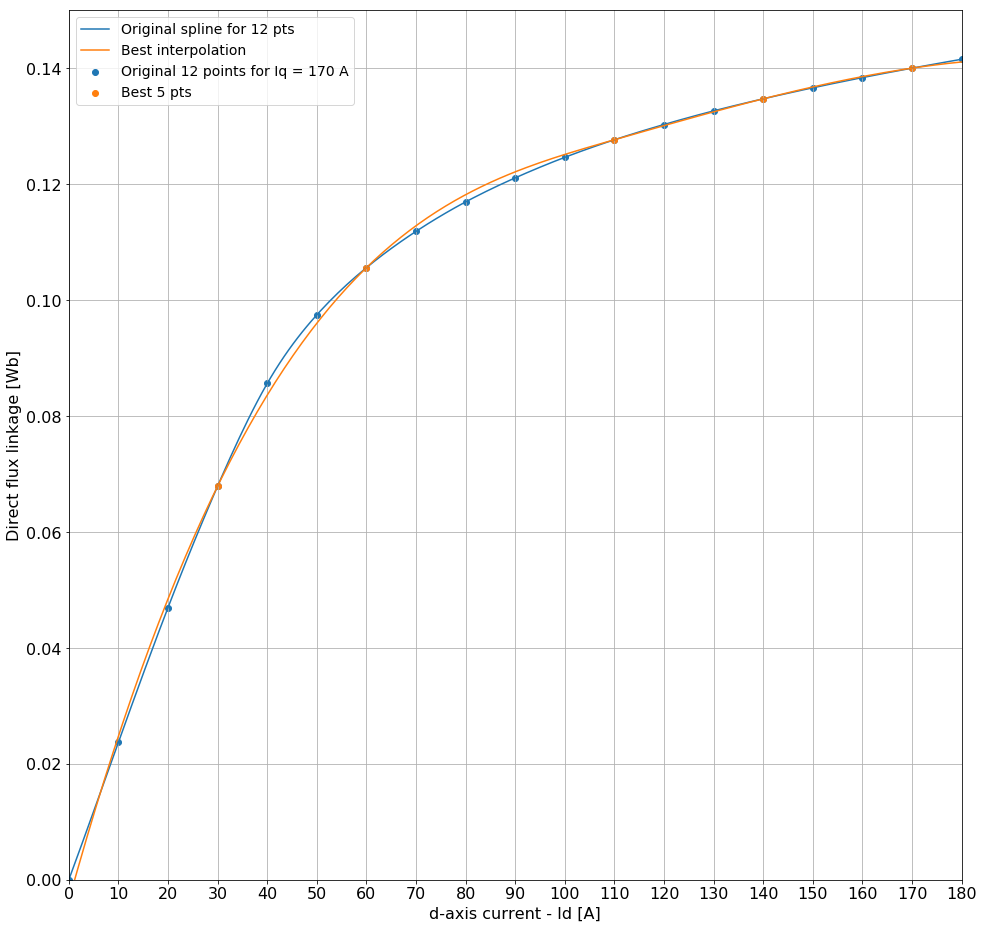

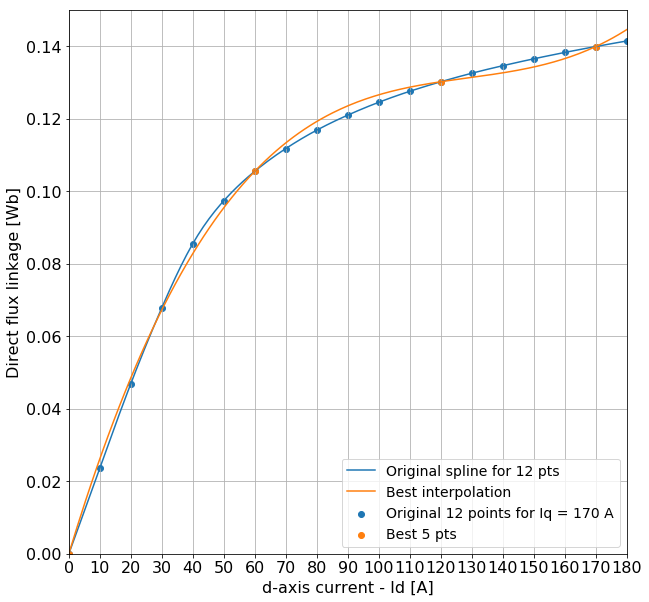

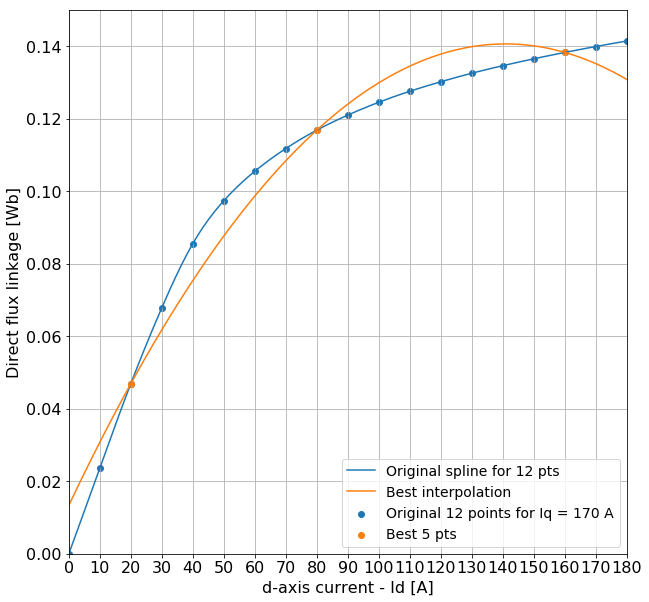

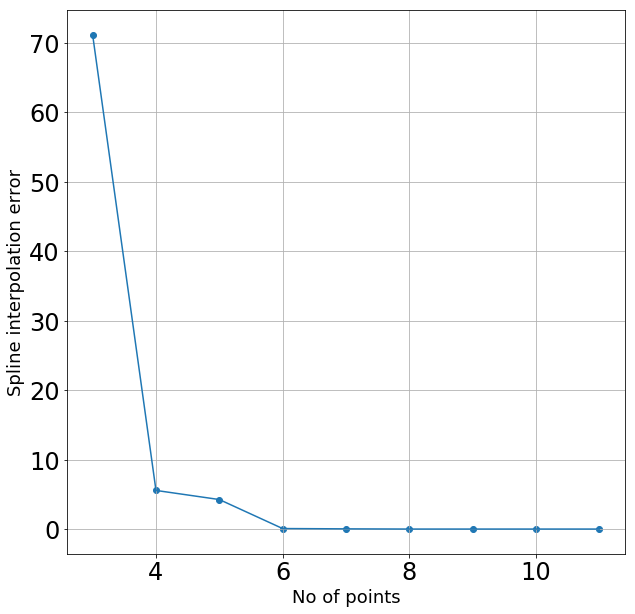

Interpolation error (sum squared error * 10 ^ 6)
+---------+------------+------------+------------+------------+------------+----------------------+
|   Iq    | pts num: 7 | pts num: 6 | pts num: 5 | pts num: 4 | pts num: 3 |      Best 5 Points   |
+=========+============+============+============+============+============+======================+
| Iq  180 | 0.01752    | 0.06243    | 1.63927    | 3.64244    | 48.55741   | [  30.   60.  100.   |
|         |            |            |            |            |            | 150.  180.]          |
+---------+------------+------------+------------+------------+------------+----------------------+
| Iq  170 | 0.01295    | 0.03259    | 1.40036    | 3.34964    | 47.59894   | [  30.   60.  110.   |
|         |            |            |            |            |            | 140.  170.]          |
+---------+------------+------------+------------+------------+------------+----------------------+
| Iq  160 | 0.00762    | 0.02517    | 1.42971    | 

In [25]:
#cubic spline interpolation

from scipy.interpolate import interp1d
from scipy import interpolate
import itertools
import sys
from pandas import DataFrame as df

#ids, dfs, iqs, xLabel, yLabel, Is = data_from_file('i_direct_flux', 1)

def sum_squared_error(gr, pred):
    gr = np.array(gr)
    pred = np.array(pred)
    return (10 ** 6) * (1 / gr.shape[0]) * sum((gr - pred) ** 2)

curve_indices = list(range(0, 19)) 
curves_for_plot = [1]# list(range(1, 13,2))
pts_for_plot = [5,4,3]

# try interpolating with only 10, 9, 8 ... 4, 3 points
sub_points_num  = list(range(len(ids)-12, 2, -1))
#sub_points_num = list(range(2,7))
headers = ['%s' %Is] + ['pts num: %d' % pts for pts in sub_points_num] + ['    Best 5 Points   ']
rows = []
x_best_5_pts = []
y_best_5_pts = []

#define total error per no of points
total_error_per_points_num = np.zeros(shape = 19)

#dataframe for error table latex
error_latex = np.zeros(shape = (19,19))

for curve in curve_indices: #pentru fiecare curba Iq
    y = dfs[:, curve] #iau fluxurile corespunzatoare
    x = ids #iau id-urile
         
    tck = interpolate.splrep(x, y, s=0) #face spline pe toate cele 12 puncte
    x_new = np.linspace(min(x), max(x), 200)
        
    # baseline = y values obtained when interpolating with all ground truth points
    baseline = interpolate.splev(x_new, tck, der=0)
    
    row = ['%s %d' % (Is, iqs[curve])]
    best_5_points =[]
   
    for points_num in sub_points_num:
        # store best configuration
        best_pts     = (x, y)
        best_interp  = (x_new, baseline)
        best_error   = sys.float_info.max
        best_err_gr  = sys.float_info.max
    
        sub_points_sets = itertools.combinations(range(len(ids)), points_num)
        for pts in sub_points_sets:
            pts = list(pts)
            x_     = x[pts]
            y_     = y[pts]
          
            if points_num == 3:
                tck_   = interpolate.splrep(x_, y_, s=0, k=2)
                y_new_ = interpolate.splev(x_new, tck_, der=0) 
            else:
                tck_   = interpolate.splrep(x_, y_, s=0)
                y_new_ = interpolate.splev(x_new, tck_) 
        
            # error -- difference between baseline interp curve and current one
            error = sum_squared_error(baseline, y_new_)
            
            if error < best_error:
                best_error  = error
                best_pts    = (x_, y_) # best points from combination
                best_interp = (x_new, y_new_) # best points from interpolation
                
                # interpolate in target points + evaluate error
                gr_interp = interpolate.splev(x, tck_, der=0)
                best_err_gr = sum_squared_error(y, gr_interp)
       
        if points_num == 5:
            best_5_points = best_pts[0]
            x_best_5_pts.append(best_pts[0])#to be used for linear interp
            y_best_5_pts.append(best_pts[1])#to be used for linear interp
            
        row.append(best_err_gr)
        error_latex[curve][points_num] = best_err_gr
        
        total_error_per_points_num[points_num] += best_err_gr
        
      
        if curve in curves_for_plot and points_num in pts_for_plot:
            plt.clf()
            plt.rcParams["figure.figsize"] = [10,10]
            plt.rcParams['xtick.labelsize']=16
            plt.rcParams['ytick.labelsize']=16
            plt.scatter(x, y, label='Original 12 points for Iq = %d A'%iqs[curve])
            plt.plot(x_new, baseline, label='Original spline for 12 pts')
            plt.scatter(best_pts[0], best_pts[1], label='Best 5 pts')
            plt.plot(best_interp[0], best_interp[1], label='Best interpolation')

            plt.ylim([0, 0.15])
            plt.xlim([0, 180])
            plt.xticks(ids)
            plt.xlabel(xLabel, fontsize = 16)
            plt.ylabel(yLabel, fontsize = 16)
           

            plt.legend(loc='best', fontsize = 14)
#             plt.title('%s = %d A , No of Id values = %d' % (Is,iqs[curve], points_num),fontsize=18)
            plt.grid()
            plt.savefig('PMASynRM_output/PMA_reduce_points_Points_num_{}for_Iq={}.pdf'.format(points_num, iqs[curve]))
            plt.show()
    
    row.append(best_5_points)
    rows.append(row)

# #tabel csv for best_5_points
# df_best_5_points = df(data = x_best_5_pts,
#                       index = iqs,
#                       columns = list(range(1,6))                                       
#                      )
# # print(df_best_5_points)
# df_best_5_points.to_csv('best_5_points.csv')

# error_latex = np.around(error_latex, decimals=2)  

# df_error_latex = df(data = error_latex[:,3:8],
#                    index = iqs,
#                    columns = list(range(3,8)))

# df_error_latex.to_csv('interp_error_points.csv')
    
    
#plotting the errors
    
x_axis = list(range(3,12))
plt.clf()
plt.rcParams["figure.figsize"] = [12, 8]
plt.rcParams['xtick.labelsize']=24
plt.rcParams['ytick.labelsize']=24

# plt.title('Spline interpolation error for different number of points',fontsize=18)
plt.scatter(x_axis,total_error_per_points_num[3:12]/12)
plt.plot(x_axis,total_error_per_points_num[3:12]/12)
plt.xlabel('No of points',fontsize=18)
plt.ylabel('Spline interpolation error',fontsize=18)
# plt.ylim([0,2])
plt.grid()
plt.savefig('PMASynRM_output/PMA_reduce_points_reconstruct_interp_error.pdf', dpi = 200)
plt.show()



print('Interpolation error (sum squared error * 10 ^ 6)')
table = plotTable(headers=headers, rows=rows, column_width=True, precision=5)
print(table)


# [REDUCE CURVES] Det. nr minim de curbe generatoare Iq  - Linear and Spline interpolation

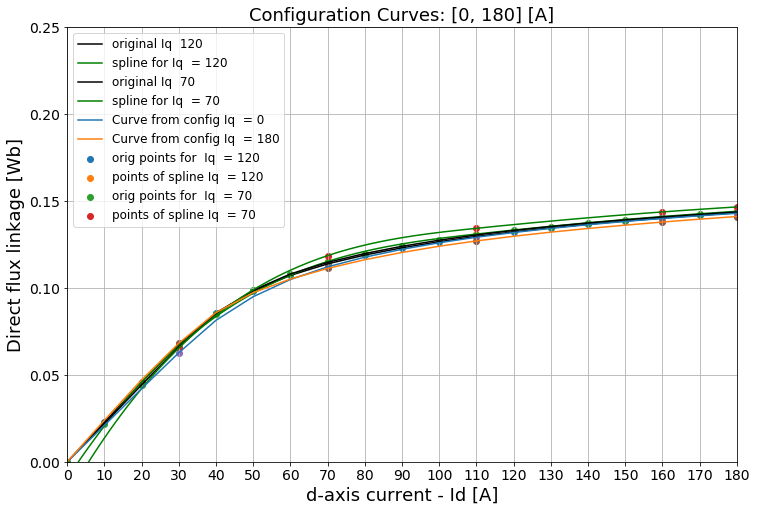

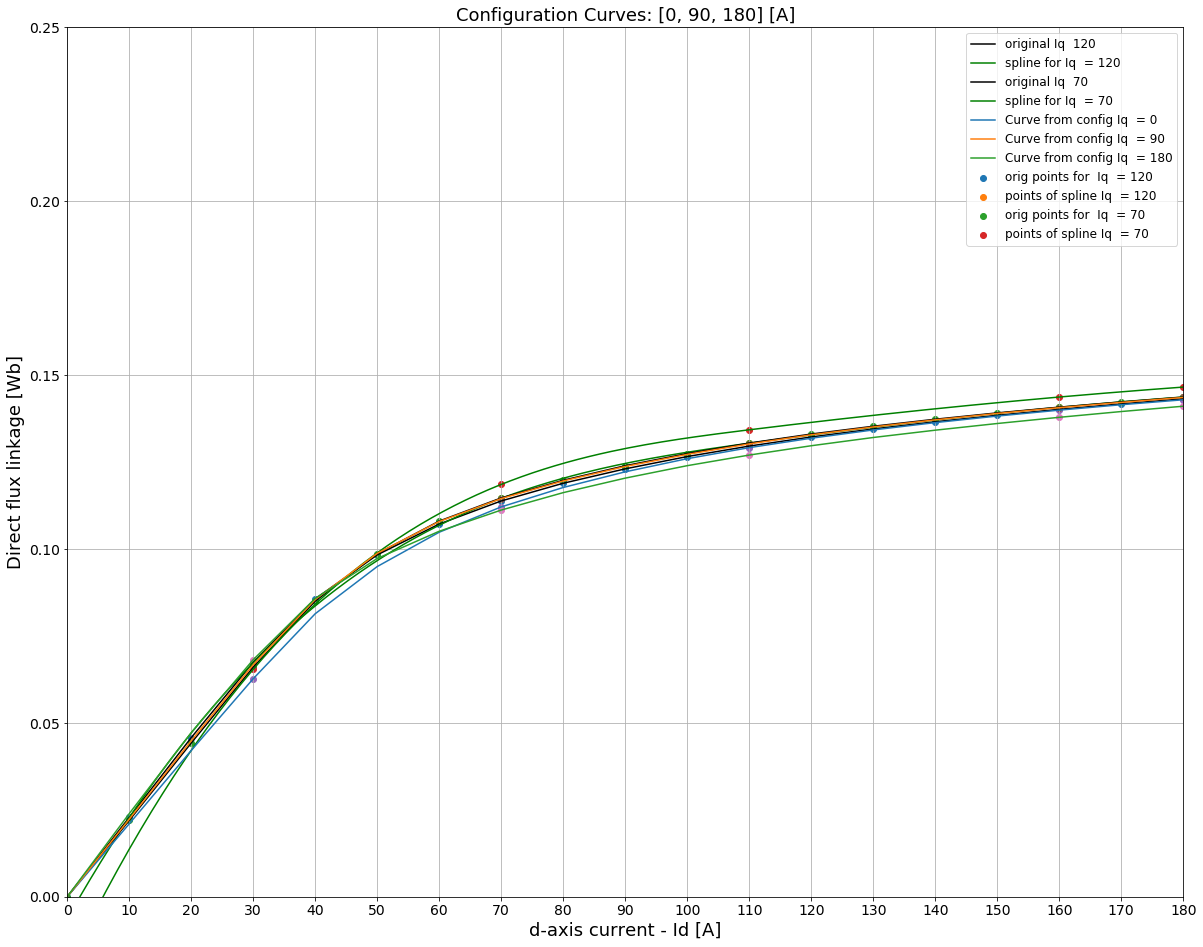

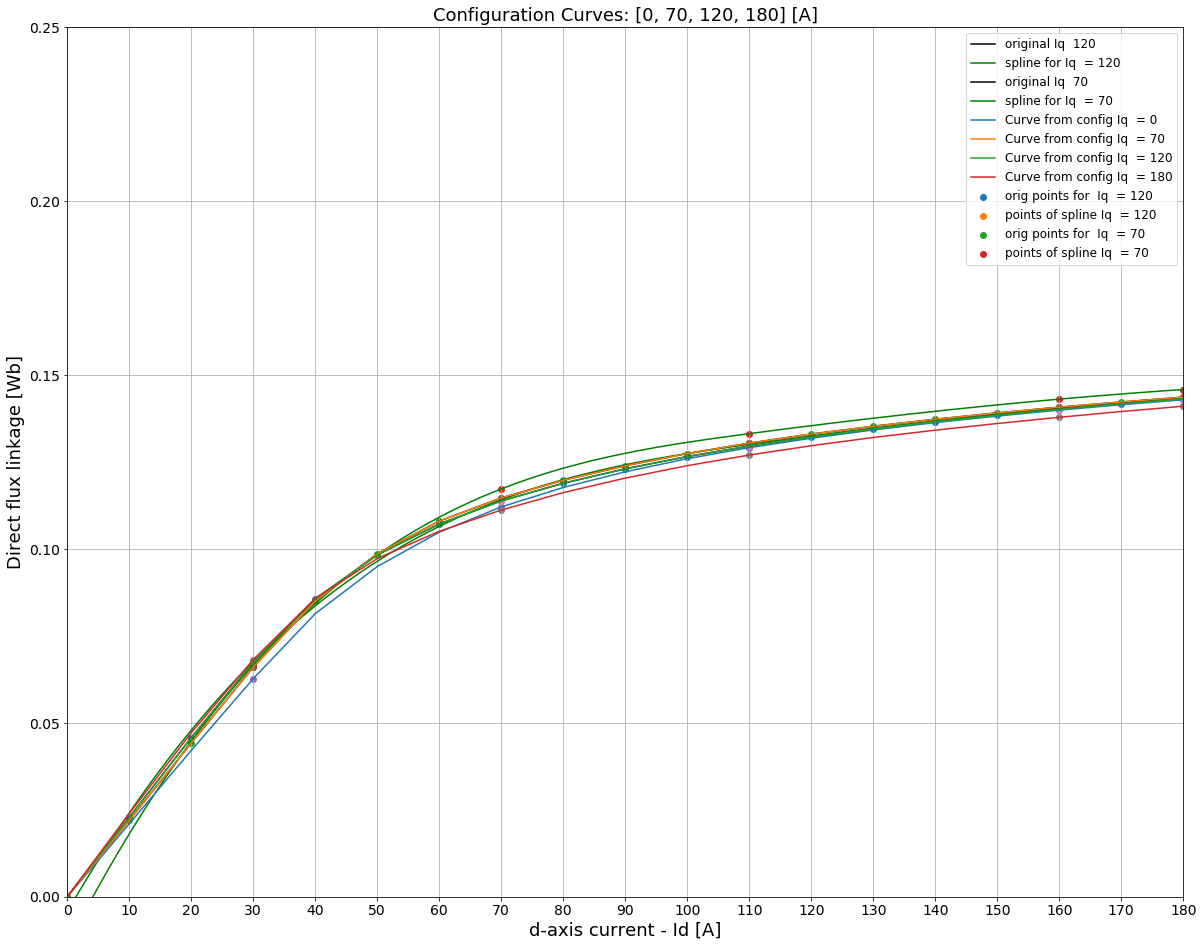

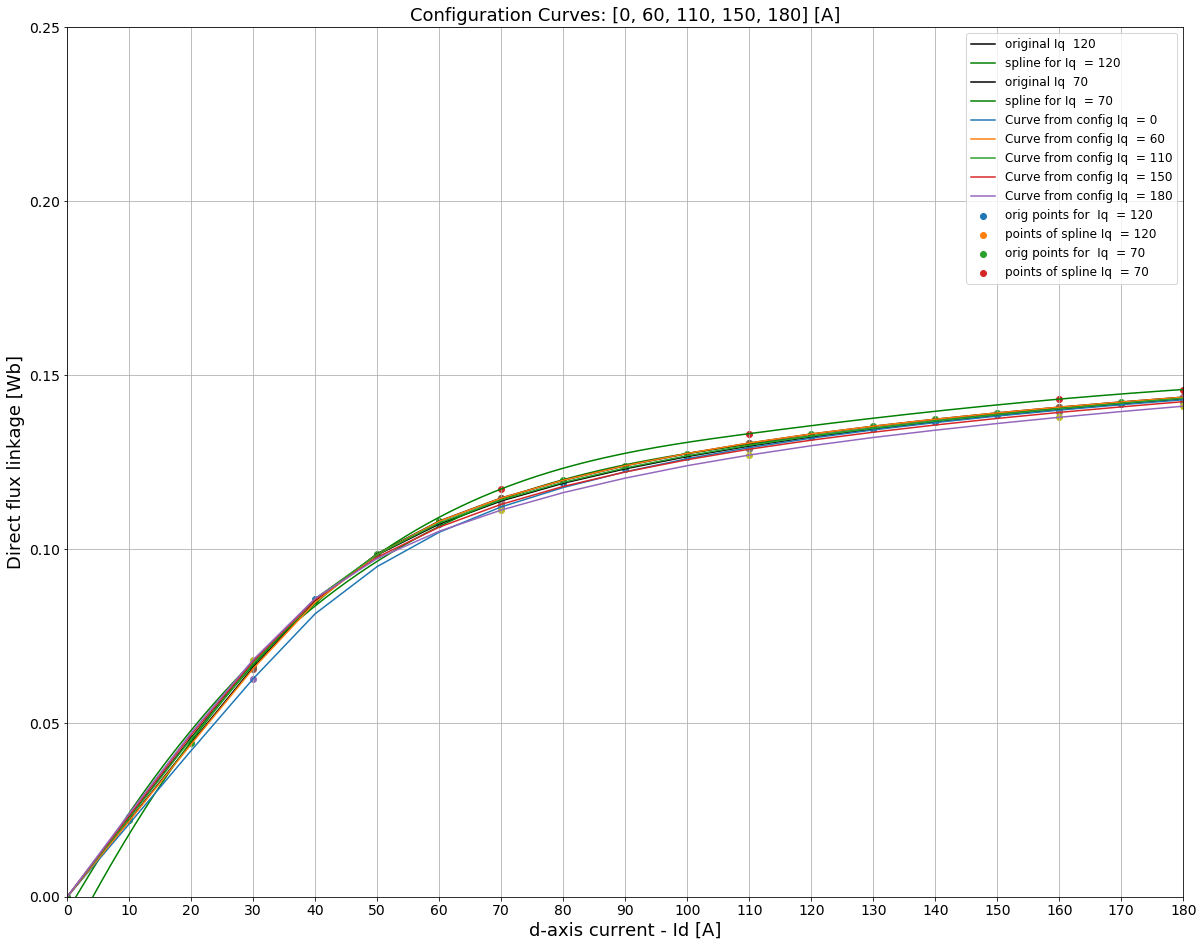

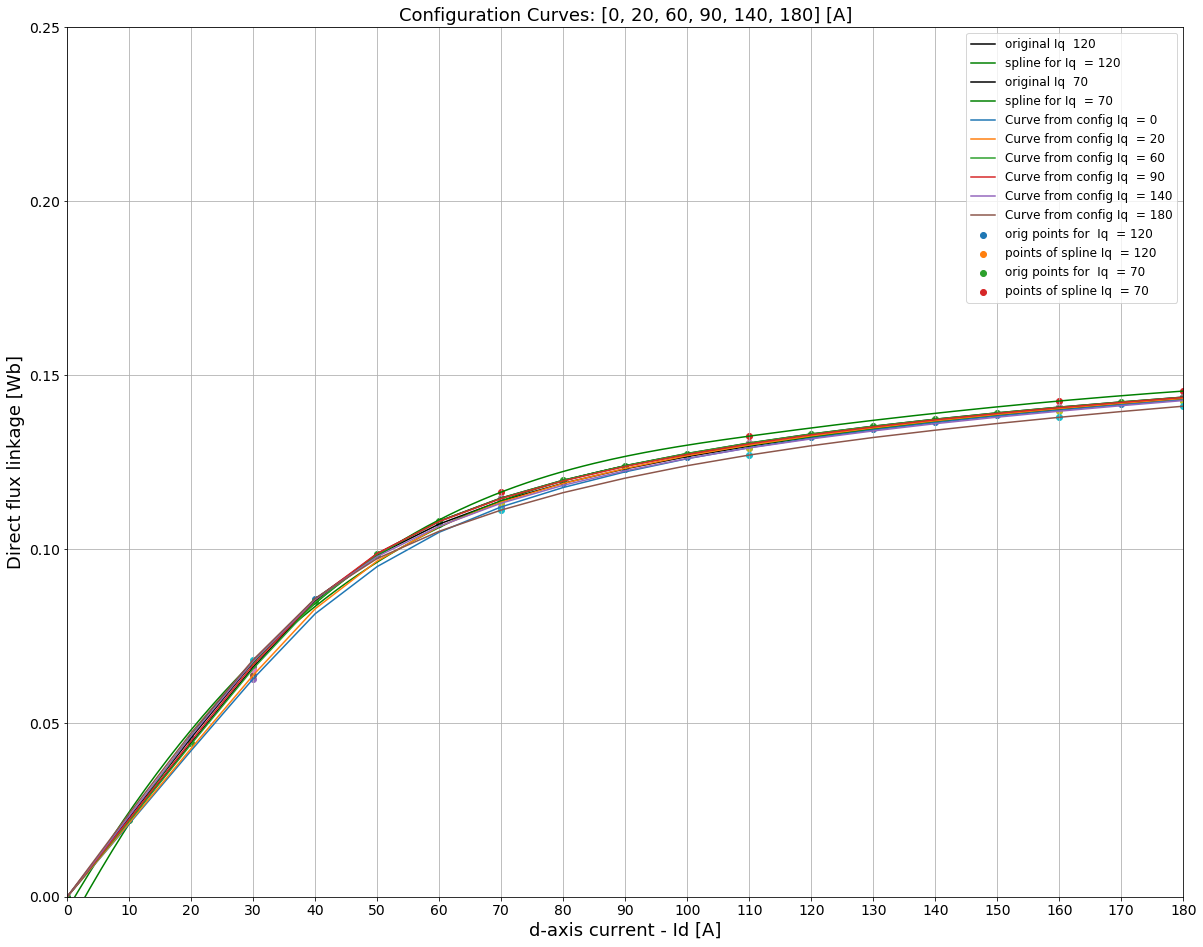

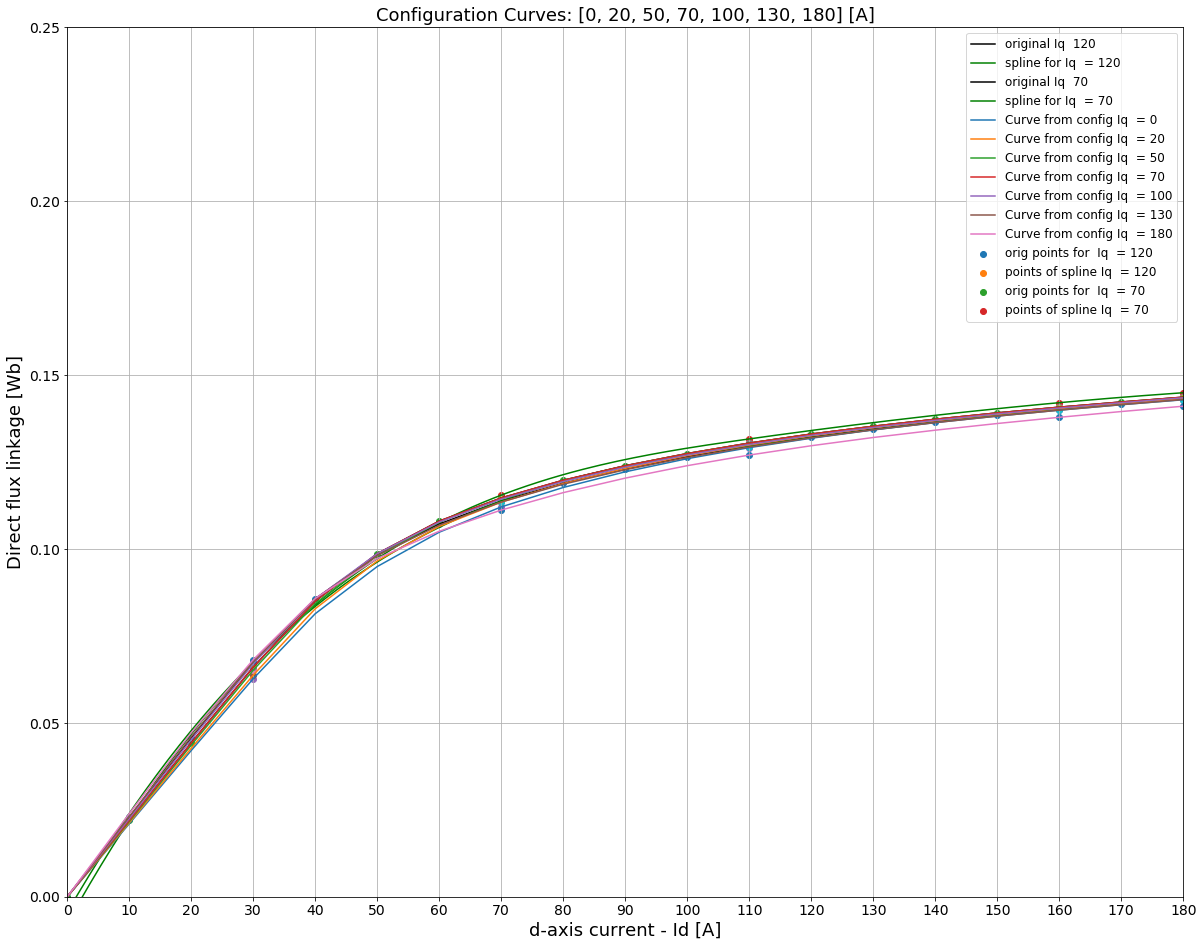

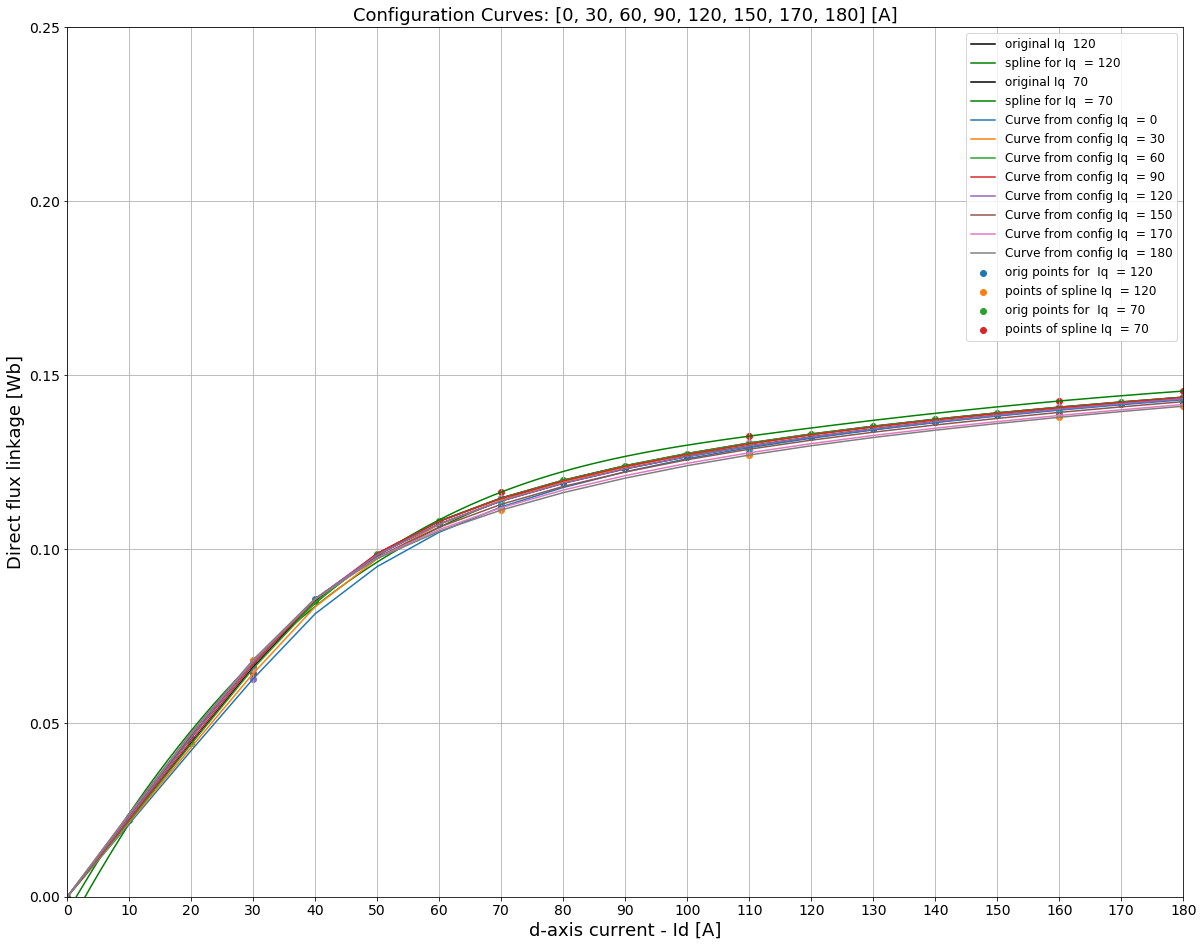

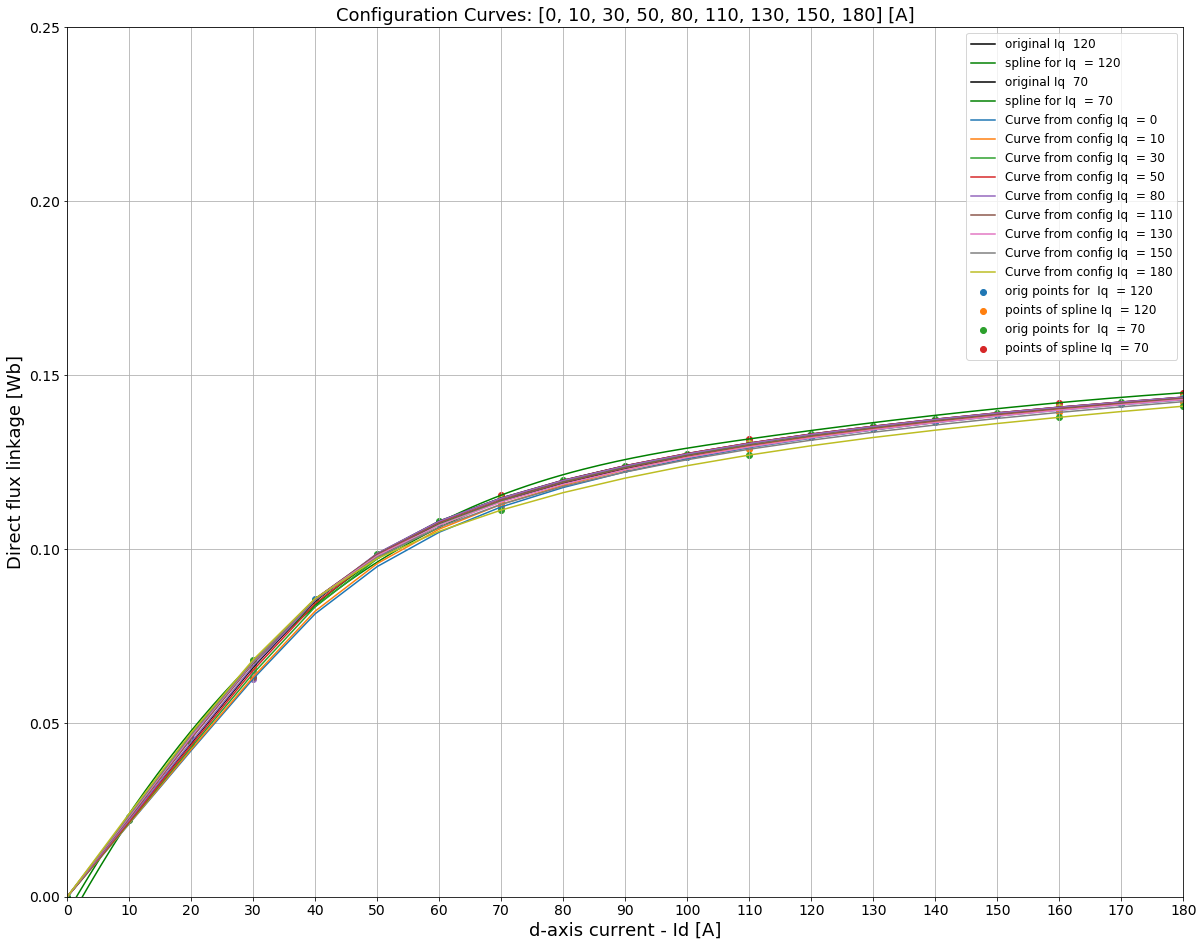

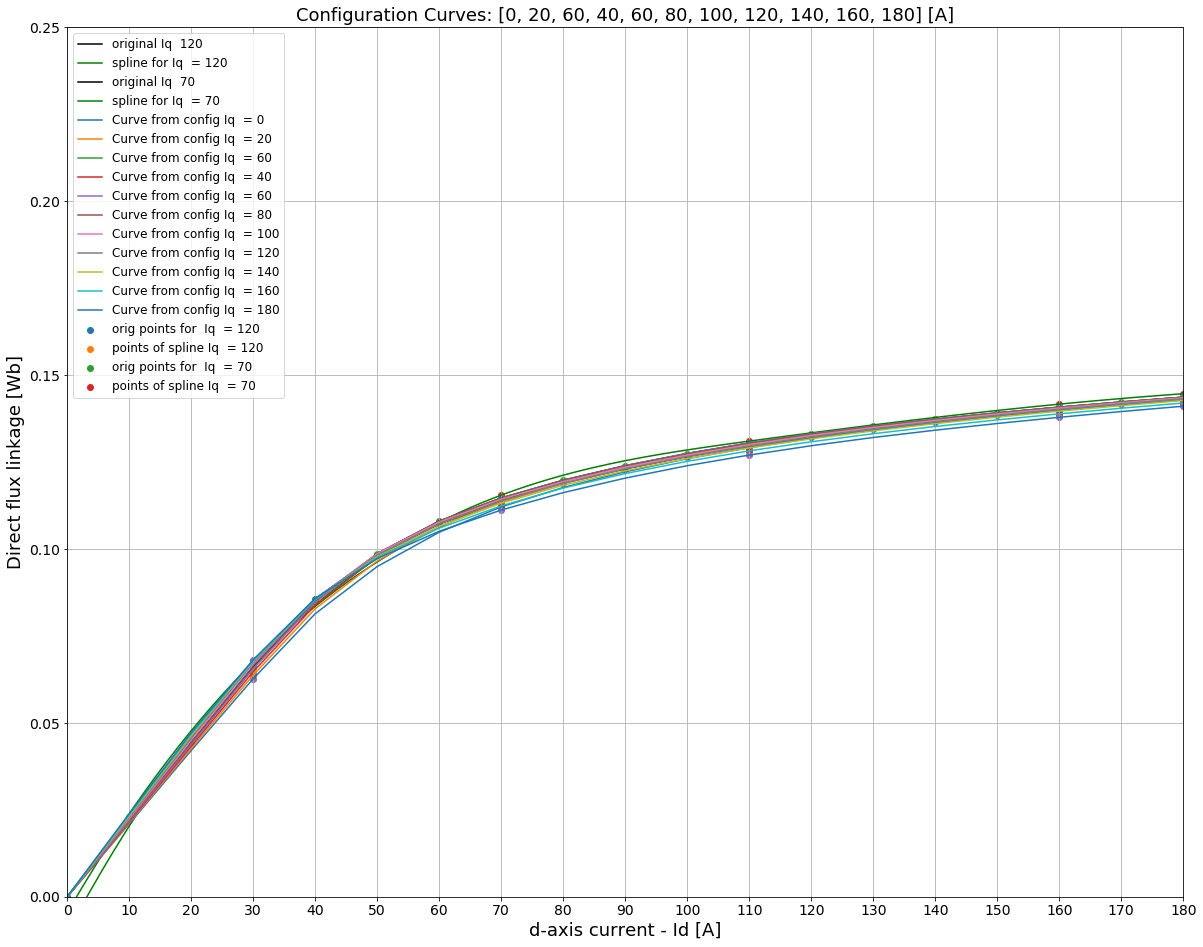

Interpolation error (sum squared error * 10 ^ 6)
+------------------------------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+------------+------------------+
| ######### Configuration ########## |     Iq 180   |     Iq 170   |     Iq 160   |     Iq 150   |     Iq 140   |     Iq 130   |     Iq 120   |     Iq 110   |     Iq 100   |     Iq 90   |     Iq 80   |     Iq 70   |     Iq 60   |     Iq 50   |     Iq 40   |     Iq 30   |     Iq 20   |     Iq 10   |     Iq 0   | error_per_config |
+====================================+==============+==============+==============+==============+==============+==============+==============+==============+==============+=============+=============+=============+=============+=============+=============+=============+=============+==

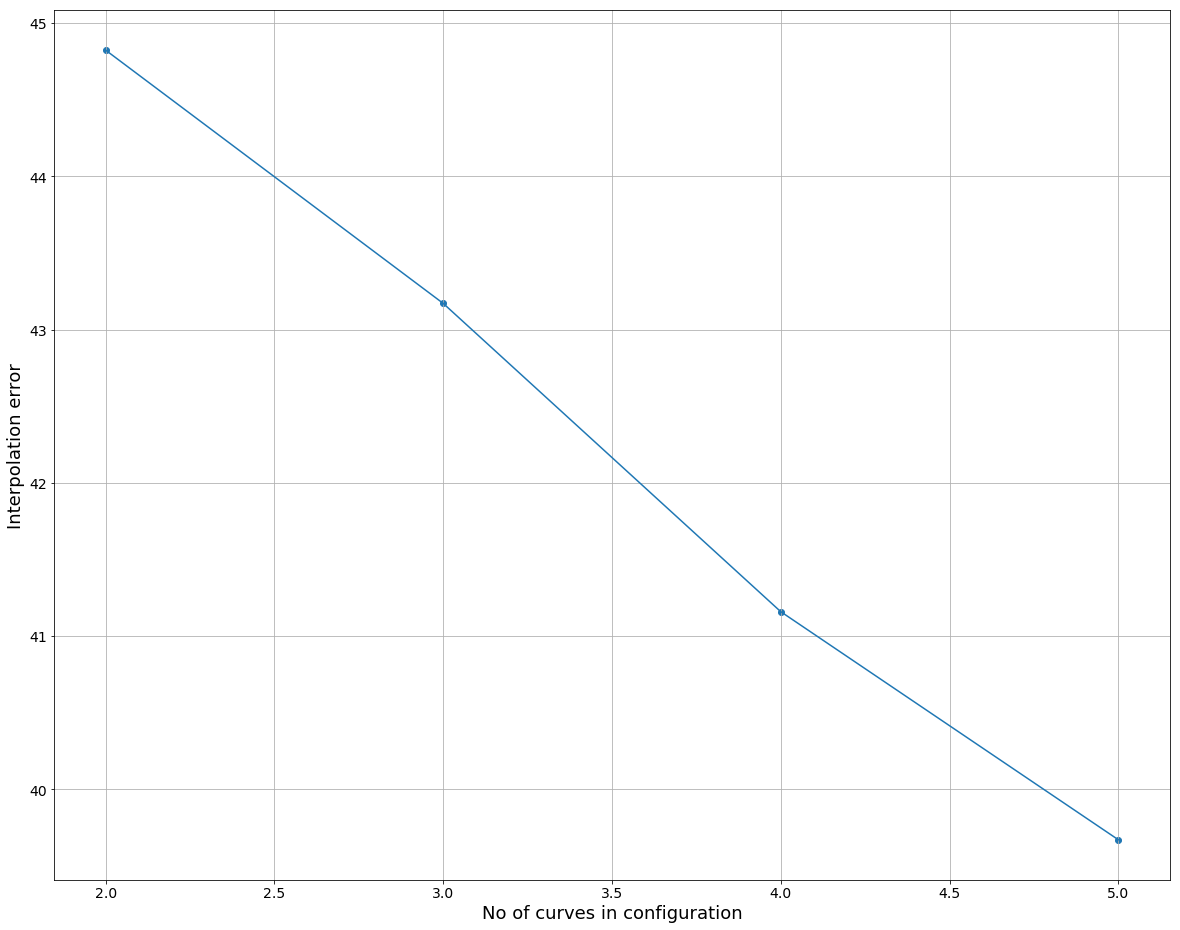

In [9]:
#
import sys
from scipy.interpolate import interp1d
from scipy import interpolate
import numpy as np
from pandas import DataFrame as df

best_points = [30., 70., 110., 160., 180.]
best_indices = [3,7,11,16,18] #indices of best-points
all_curves = list(range(19))
curves_for_plot = [11,6]

plt.clf()
plt.rcParams["figure.figsize"] = [20,16]
plt.rcParams['xtick.labelsize']=14
plt.rcParams['ytick.labelsize']=14


#config_curves = [[11,0],[11,6,0],[11,8,4,0],[11,9,6,3,0],[11,8,6,4,2,0],[11,9,7,6,5,1,0]]
config_curves = [[18,0],[18,9,0],[18,11,6,0],[18,12,7,3,0],[18,16,12,9,4,0],[18,16,13,11,8,5,0],[18,15,12,9,6,3,1,0],[18,17,15,13,10,7,5,3,0],[18,16,12,14,12,10,8,6,4,2,0]]
error_per_config = np.zeros(shape = len(config_curves))

# headers = ['%s' %Is] + ['no of curves: %d' % len(nr)for nr in config_curves]+['best no of curves']+['######### best config #########']
headers = ['######### Configuration ##########'] +['   Iq %d   ' % iqs[index] for index in all_curves] + ['error_per_config']
rows    = []

#define errors per curve in each config
error_per_curve = np.zeros(shape=(len(all_curves),len(config_curves)))

#define total error per config
error_per_config = np.zeros(shape = len(config_curves))

#define error for latex tables

# flux pt best_points
def flux_for_curves_config(curves_config_indices):
    flux = [[] for i in range(19)]
    for curve in curves_config_indices:
        for idx in best_indices:
            flux[curve].append(dfs[idx][curve])
    return flux    

#incadrez curba intre doua curbe din config

def border_curves(curve, interval):
    pos = 0
    for id in interval:
        if iqs[curve] > iqs[id]:
            pos+=1
        else:
            if iqs[curve] == iqs[id]:
                if pos+1 == len(interval):
                    return pos, pos-1
                else:
                    return pos, pos+1
         
    return pos-1, pos 

def sum_squared_error(gr, pred):
    gr = np.array(gr)
    pred = np.array(pred)
    return (10 ** 6) * (1 / gr.shape[0]) * sum((gr - pred) ** 2)

for idx in range(len(config_curves)): #iau o configuratie
    indices = config_curves[idx]
    row =[[iqs[i] for i in indices]]
  
    for curve in all_curves: #pt fiecare curba
            
        start, end = border_curves(curve, indices)  #gasesc curbele care imi incadreaza curba de aproximat
        flux = flux_for_curves_config([start, end]) # retin fluxurile pentru curbele din config
       
        #interpolare liniara                       
        
        alpha = 1-((iqs[curve]-iqs[start])/(iqs[end]-iqs[start]))
             
        flux_approx = []
        for i in range(5):
            flux_approx.append(alpha * flux[start][i] + (1-alpha)*flux[end][i])
        
        ##Spline##
        
        #plotez cu toate cele 12 pcte
        y = dfs[:, curve] #iau fluxurile corespunzatoare
        x = ids #iau Id-urile

        tck = interpolate.splrep(x, y, s=0) #fac spline pe toate cele 12 puncte
        x_new = np.linspace(min(x), max(x), 200) #creez mai multe puncte

        # baseline = y values obtained when interpolating with all ground truth points
        baseline = interpolate.splev(x_new, tck, der=0) 
              
        # interpolate in best x points
        x_     = best_points
        y_     = flux_approx
        tck_   = interpolate.splrep(x_, y_, s=0)
        y_new_ = interpolate.splev(x_new, tck_, der=0)            
        
      # error -- difference between baseline interp curve and current one
        error = sum_squared_error(baseline, y_new_)
           
#         print('%s: %d, curves num: %d' % (Is,iqs[curve], len(indices)))
        
        if curve in curves_for_plot:
            
#             color=next(ax._get_lines.prop_cycler)['color']
            plt.scatter(x, y, label='orig points for  %s = %d' %(Is, iqs[curve]))
            plt.plot(x, y, label='original %s %d' %(Is, iqs[curve]), color = 'black')
            plt.scatter(x_, y_, label='points of spline %s = %d' %(Is, iqs[curve]))
            plt.plot(x_new, y_new_, label='spline for %s = %d' %(Is, iqs[curve]), color = 'green')

            plt.ylim([0, 0.25])
            plt.xlim([0, 180])
            plt.xticks(ids)
            plt.xlabel(xLabel)
            plt.ylabel(yLabel)
            plt.legend(loc='best')
            plt.title('Configuration Curves: %s [A]'%[iqs[i] for i in indices],fontsize=18)
            
           
        error_per_curve[curve][idx] = error
        error_per_config[idx]+=error
        
        row.append(error)
         
    row.append(error_per_config[idx]/19)
    
    rows.append(row) 
    
    
    for i in indices:
        df = dfs[:, i]
        plt.plot(ids, df, label='Curve from config %s = %d' %(Is,iqs[i]))#, color = 'black')
        plt.scatter(best_points, [dfs[j][i] for j in best_indices])#, color = 'black')
        plt.ylim([0, 0.25])
        plt.xlim([0, 180])
        plt.xticks(ids)
        plt.xlabel(xLabel,fontsize=18)
        plt.ylabel(yLabel,fontsize=18)
        plt.legend(loc='best',fontsize=12)
    plt.grid()
    plt.savefig('PMASynRM_output/PMA_reduce_curves_reconstruct_intepr_{}curvesConfig.pdf'.format(len(indices)),dpi = 200)
    plt.show()



print('Interpolation error (sum squared error * 10 ^ 6)')
table = plotTable(headers=headers, rows=rows, column_width=True, precision=5)
print(table)

## error for latex table

# df_error_for_latex = df(data = np.around(error_per_curve[:,0:4], decimals=2),
#                        index = iqs,
#                         columns = list(range(2,6))
#                        )
# print(df_error_for_latex)
# df_error_for_latex.to_csv('PMA_inter_error_curves.csv')


#Plotting the interpolation error

plt.clf()
plt.rcParams["figure.figsize"] = [20,16]
plt.rcParams['xtick.labelsize']=14
plt.rcParams['ytick.labelsize']=14

plt.scatter([2,3,4,5],error_per_config[0:4]/12)
plt.plot([2,3,4,5], error_per_config[0:4]/12)
plt.xlabel('No of curves in configuration',fontsize=18)
plt.ylabel('Interpolation error',fontsize=18)
plt.grid()
plt.savefig('PMASynRM_output/PMA_reduce_curves_interp_error.pdf', dpi = 200)
plt.show()

